##1. Tải bộ dữ liệu:

In [ ]:
!gdown --id 1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1qiUDDoYyRLBiKOoYWdFl_5WByHE8Cugu
To: /content/Auto_MPG_data.csv
100% 15.4k/15.4k [00:00<00:00, 28.9MB/s]


##2. Import các thư viện cần thiết:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##3. Cài đặt giá trị ngẫu nhiên cố định:

In [ ]:
random_seed = 59
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

##4. Cài đặt thiết bị tính toán:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##5. Đọc bộ dữ liệu:

In [ ]:
dataset_path = '/content/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)

##6. Tiền xử lý bộ dữ liệu:

In [ ]:
# a) Tách đặc trưng X và nhãn y:
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [ ]:
# b) Chia bộ dữ liệu train/val/test:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_seed,
    shuffle=is_shuffle
)

In [ ]:
# c) Chuẩn hóa đặc trưng đầu vào:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

##7. Xây dựng DataLoader:

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

##8. Xây dựng mạng MLP:

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.output(x)
        return x.squeeze(1)

In [ ]:
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 64

model = MLP(input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim).to(device)

##9. Khai báo hàm loss và optimizer:

In [ ]:
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

##10. Xây dựng hàm tính điểm R2:

In [ ]:
def r_squared(y, y_pred):
    y = torch.Tensor(y).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    y_mean = torch.mean(y)
    ss_tot = torch.sum((y - y_mean) ** 2)
    ss_res = torch.sum((y - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

##11. Huấn luyện mô hình:

In [ ]:
epochs = 100
train_losses, val_losses, train_r2, val_r2 = [], [], [], []

for epoch in range(epochs):
    train_loss = 0.0
    train_target, val_target, train_predict, val_predict = [], [], [], []

    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predict.extend(y_pred.tolist())
        train_target.extend(y_batch.tolist())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict).item())

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            val_loss += loss.item()
            val_predict.extend(y_pred.tolist())
            val_target.extend(y_batch.tolist())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2.append(r_squared(val_target, val_predict).item())

    print(f'Epoch {epoch + 1}/{epochs}:\ttrain_loss: {train_loss:.3f}\tval_loss: {val_loss:.3f}')

Epoch 1/100:	train_loss: 12.497	val_loss: 8.330
Epoch 2/100:	train_loss: 11.710	val_loss: 8.331
Epoch 3/100:	train_loss: 11.858	val_loss: 8.277
Epoch 4/100:	train_loss: 11.874	val_loss: 8.345
Epoch 5/100:	train_loss: 11.833	val_loss: 8.228
Epoch 6/100:	train_loss: 11.500	val_loss: 8.246
Epoch 7/100:	train_loss: 11.812	val_loss: 8.310
Epoch 8/100:	train_loss: 11.811	val_loss: 8.308
Epoch 9/100:	train_loss: 12.131	val_loss: 8.281
Epoch 10/100:	train_loss: 11.470	val_loss: 8.231
Epoch 11/100:	train_loss: 11.994	val_loss: 8.160
Epoch 12/100:	train_loss: 12.085	val_loss: 8.239
Epoch 13/100:	train_loss: 12.564	val_loss: 8.511
Epoch 14/100:	train_loss: 11.575	val_loss: 8.329
Epoch 15/100:	train_loss: 11.780	val_loss: 8.328
Epoch 16/100:	train_loss: 11.537	val_loss: 8.173
Epoch 17/100:	train_loss: 11.415	val_loss: 8.253
Epoch 18/100:	train_loss: 11.625	val_loss: 8.301
Epoch 19/100:	train_loss: 11.365	val_loss: 8.173
Epoch 20/100:	train_loss: 11.763	val_loss: 8.337
Epoch 21/100:	train_loss: 11.

##12. Đánh giá mô hình:

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_r2 = r_squared(y_test, y_pred)
    print(f'Test R2: {test_r2:.3f}')

Test R2: 0.834


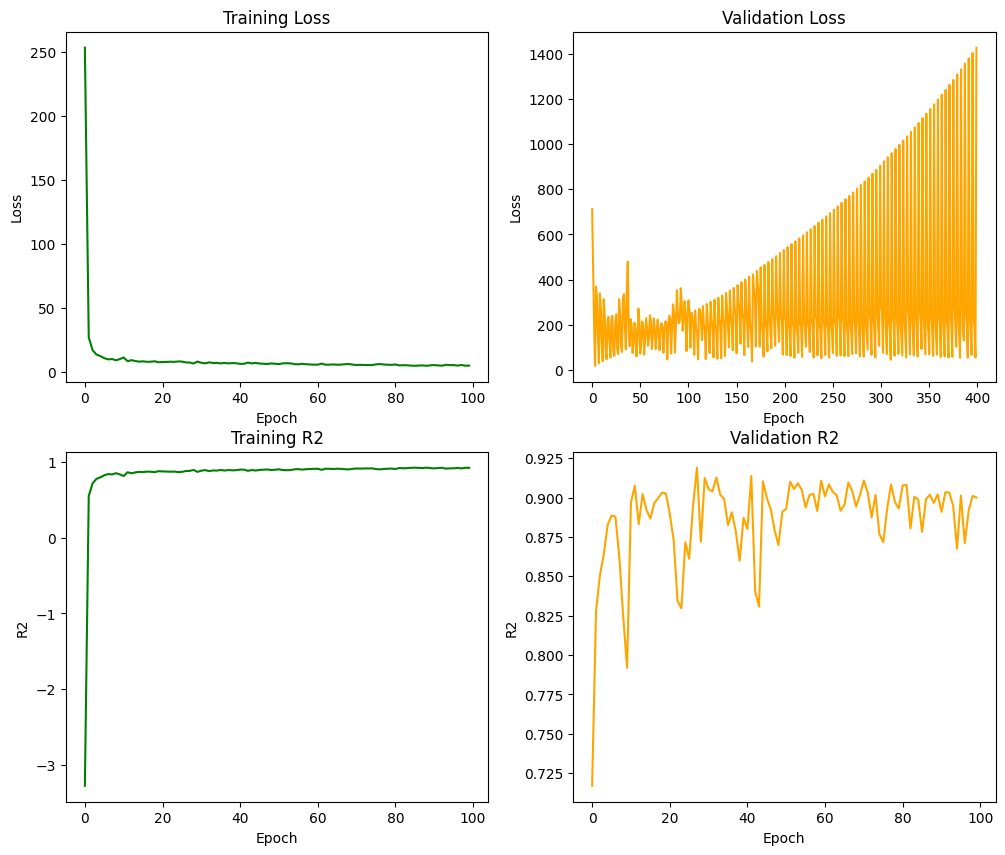

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_r2, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training R2')

ax[1, 1].plot(val_r2, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation R2')

plt.show()